## 8 ARCHITECTURE DU FRAMEWORK DE RÉSOLUTION

### 8.1. PHILOSOPHIE DE CONCEPTION

Avant de plonger dans les détails techniques, comprenons le problème de conception auquel nous sommes confrontés.

Tenter de proposer une solution au CVRPTW, ce n'est pas seulement "écrire et implémenter un algorithme". C'est orchestrer plusieurs composants qui doivent travailler ensemble : <br>
Charger les données, <br>
évaluer les solutions, <br>
construire des solutions initiales,<br> 
les améliorer, et enfin, <br>
sauvegarder les résultats pour traitement. <br>
Si on fait un seul script, on se retrouve avec un code immaintenable, impossible à tester et surtout inexploitable (sans même parler du risque de tout casser à chaque modification).

La question de design fondamentale est donc : **comment organiser ce code pour qu'il soit à la fois modulaire, extensible, et *simple* à utiliser ?**

Notre réponse s'inspire des principes du [génie logiciel moderne¹](#1) : séparation des responsabilités (Separation of Concerns). <br>

Chaque module a un rôle précis et bien défini. <br>
- Un module qui charge les instances ne doit pas savoir comment on évalue une route. <br>
- Un module qui évalue une route ne doit pas savoir quel algorithme d'optimisation on utilise. <br>

Cette séparation crée des frontières claires qui facilitent le développement, le test, et l'extension du framework.

Cette architecture suit également les principes SOLID de la programmation orientée objet, notamment le principe de responsabilité unique (Single Responsibility Principle) et le principe ouvert/fermé (Open/Closed Principle), permettant d'étendre le framework sans modifier le code existant. notamment, rajouter des solveurs et relancer des tests sans tout faire planter.

 ### 8.2. MODULES PRINCIPAUX

Nous décrirons ici les modules principaux du "framework" de résolution, si vous voulez la documentation, vous pouvez aller lire "frameworkdoc.ipynb", le code source se trouve dans le dossier "framework".
 #### 8.2.1. InstanceFileManager : Le pont vers les données

 **Rôle :** Charger les instances au format vrplib et les transformer en objets Python manipulables.

**Pourquoi un module dédié ?** 

Le format vrplib, introduit par [Augerat et al.²](#2) et standardisé pour la [communauté de recherche en VRP³](#3), est spécifique avec ses propres conventions (matrices de distance, fenêtres temporelles, etc.). Isoler cette logique de parsing permet de changer de format d'entrée sans toucher au reste du code, respectant ainsi le principe d'inversion de dépendance.

**Responsabilités**

* Parser les fichiers `.vrp` & `.sol` (coordonnées, demandes, capacité, time windows)
* Calculer les matrices de distance (euclidienne 2D selon la norme de [Solomon⁴](#4))
* Créer un objet Instance contenant toutes les données structurées
* Distinguer automatiquement CVRP vs CVRPTW selon la présence de fenêtres temporelles et contraintes de capacité.

**Interface principale :**

```python
# Code non voué à être éxécuté
manager = InstanceFileManager(data_dir="/data")
instance = manager.load_instance("C101")

# L'objet Instance expose :
# - instance.dimension : nombre total de nœuds (clients + dépôt)
# - instance.capacity : capacité des véhicules
# - instance.distance_matrix : matrice des distances [n x n]
# - instance.demands : demandes de chaque client
# - instance.ready_times, instance.due_dates : fenêtres temporelles
# - instance.service_times : durées de service
```

#### 8.2.2. RouteEvaluator : Le juge des solutions

**Rôle :** Évaluer la qualité et la faisabilité d'une route donnée selon les contraintes du CVRPTW.

**Pourquoi séparer l'évaluation ?**

L'évaluation est le cœur de tout algorithme d'optimisation. <br>
Chaque opérateur, chaque métaheuristique, va appeler l'évaluateur des centaines de milliers de fois. Cette logique doit être centralisée, optimisée, et correcte.<br>
[La littérature en optimisation combinatoire⁵](#5) insiste sur l'importance d'une évaluation efficace pour la performance globale des métaheuristiques.

**Responsabilités :**

* Calculer le coût d'une route (somme des distances selon la métrique euclidienne fournie)
* Vérifier les contraintes de capacité
* Vérifier les contraintes temporelles strictes du CVRPTW
* Calculer les temps d'arrivée chez chaque client
* Retourner un verdict : faisable ou non, et (quand voulut) pourquoi


**Contrainte temporelle stricte :**

La contrainte temporelle du CVRPTW choisi est plus stricte que dans le VRPTW classique que nous connaissons : 

Un véhicule ne peut PAS attendre si il arrive avant l'ouverture de la fenêtre temporelle.<br> 
Il doit repartir immédiatement. Cette contrainte, définie dans notre modélisation en section 3, <br>
change fondamentalement le calcul des temps d'arrivée.

Soit un véhicule visitant les clients *i* puis *j*. Le temps d'arrivée ($t_j$) chez *j* est $t_j = t_i + s_i + d_ij$
où:
- $s_i$ est le temps de service chez $i$
- $d_ij$ la durée du trajet (égale à la distance, ratio 1:1)

Si $t_j$ < $a_j$ (arrivée avant ouverture du client), la route est **infaisable**. Pas d'attente prévue.
Si $t_j$ > $b_j$ (arrivée après fermeture du client), la route est également **infaisable.**
Il est cependant possible de repartir de chez le client après son horaire de service.

**Interface principale :**

```python
# Code non voué à être éxécuté
evaluator = RouteEvaluator(instance)

# Évalue une route
route = [5, 3, 7, 8, 10]  # Séquence de clients (sans le dépôt)
evaluation = evaluator.evaluate_route(route)

# Résultat :
# - evaluation.cost : coût total (distance)
# - evaluation.is_feasible : bool
# - evaluation.total_demand : charge totale
# - evaluation.capacity_violation : si dépassement
# - evaluation.time_window_violations : liste des violations temporelles
```

#### 8.2.3. Solution : La représentation d'une solution VRP

**Rôle:** Encapsuler une solution complète (ensemble de routes) avec ses métriques et opérations.

**Pourquoi une classe dédiée ?** 

Une solution VRP n'est pas une simple structure de données. <br>
C'est un objet mathématique complexe avec des invariants à maintenir et des opérations à garantir. <br>
L'approche orientée objet permet d'encapsuler cette complexité et de garantir la cohérence de la représentation. Elle permet également un accès en O(1), peux importe comment on recherche quelque chose.

**Responsabilités :**

* Stocker les routes : `[[route1], [route2], ...]`
* Calculer automatiquement le coût total (somme des coûts de routes) de manière optimisée
* Compter les véhicules utilisés
* Fournir des méthodes de manipulation (ajouter/retirer un client)
* Valider la cohérence globale (tous les clients visités exactement une fois)
* Vérifier sa propre validité de manière très rapide

**Invariants maintenus :**

* Chaque client apparaît dans exactement une route (partition de $C$
* Les routes sont stockées sans le dépôt (implicite au début et à la fin, économie de données)
* Le coût est toujours synchronisé avec les routes
* Aucune route vide n'est conservée


**Interface principale :**

```python
# Code non voué à être éxécuté
solution = Solution(instance, evaluator)

# Ajoute des routes
solution.routes = [[5, 3, 7], [8, 10, 11], [9, 6, 4]]

# Propriétés automatiquement calculées
print(solution.total_cost)          # Coût total
print(solution.n_vehicles_used)     # Nombre de véhicules utilisés
print(solution.route_costs)         # Coûts individuels des routes

# Validation complète
is_valid, message = solution.is_valid_vrp(instance, evaluator)
```

#### 8.2.4. Constructors : Générer des solutions initiales

**Rôle :** Créer une solution initiale faisable à partir de rien, rapidement et efficacement.

**Pourquoi des constructeurs ?**

La qualité de la solution initiale impacte fortement [la convergence des métaheuristiques⁶](#6).<br>
Partir d'une solution aléatoire donne de mauvais résultats. <br>
Partir d'une solution gloutonne intelligente accélère drastiquement la convergence, comme [démontré par Gendreau et al⁷](#7).

**Constructeurs implémentés :**

**aléatoire**

Un aglorithme assez simple ayant juste pour but de vérifier rapidement si les constructeurs marchaient, assez anecdotique au vus des piètres résultats offers par cet algrotihme.

Algorithme:
- Mélange les clients aléatoirement
- Essaie de les insérer dans l'ordre mélangé
- Si impossible → nouvelle route

**Complexité:** O(n²)<br>
**Qualité:** Mauvaise (mais utile pour tests/benchmarks)

**Nearest Neighbor (Plus Proche Voisin)**

[Algorithme glouton simple introduit par Rosenkrantz et al.⁸](#8)
À chaque étape, on ajoute à la route courante le client non visité le plus proche, tant que les contraintes sont respectées. Si plus possible, on commence une nouvelle route.

**Complexité:** O(n²)<br>
**Qualité:** Moyenne (bon point de départ pour optimisation)

**Savings Algorithm (Algorithme des économies)**

Basé sur le principe de [Clarke & Wright (1964)⁹](#9), l'une des heuristiques constructives les plus influentes en VRP.<br>
L'idée : au lieu de servir chaque client avec un véhicule dédié (solution triviale mais coûteuse), on fusionne des routes si l'économie est positive.

L'économie de fusionner deux routes (0,$i$,0) et (0,$j$,0) en (à,$i$,$j$,0) est : $s_ij = d_0i + d_0j - d_ij$

On trie simplement les économies par ordre décroissant et on fusionne tant que c'est faisable (avec respect des contraintes de capacité et temporelles via routemanager).

**complexité:** 0(n²log(n)) dû au tri.
**Qualité:** Haute (probabilité forte d'une economie de temps à long termes)

**Interface:**
```python
# Code non voué à être éxécuté
import solvermanager.constructors

# Nearest Neighbor
solution = constructors.nearest_neighbor(instance, evaluator, seed=42)

# Savings (parallèle)
solution = constructors.savings_parallel(instance, evaluator, seed=42) # permet une meilleure solution, mais pas un meilleur temps, n'étant pas basé sur du multithreading
```

#### 8.2.5. Operators : Transformer les solutions

**Rôle** : Définir les opérateurs de voisinage qui modifient localement une solution.

**Pourquoi isoler les opérateurs ?** Les opérateurs de voisinage sont le vocabulaire commun de toutes les [métaheuristiques de recherche locale¹⁰](#10). <br>
LocalSearch, SimulatedAnnealing, ALNS, Tabu Search... tous utilisent les mêmes opérateurs de base. Centraliser cette logique évite la duplication et facilite l'ajout de nouveaux opérateurs, ainsi que permet un debug et optimisation rapide.

**Opérateurs implémentés** :

**Relocate (Déplacement)**
Opérateur intra-route ou inter-routes introduit par [Savelsbergh¹¹](#11). <br>
Déplace un client d'une position à une autre, éventuellement vers une route différente.

```
Route 1: [5, 3, 7, 8]
Route 2: [10, 11]

Relocate client 7 de Route 1 vers Route 2
→ Route 1: [5, 3, 8]
→ Route 2: [10, 7, 11]
```
**Complexité** : O(1) par tentative, mais O(n²) pour explorer tout le voisinage.

**2-opt**

Opérateur intra-route classique proposé par [Croes (1958)¹²](#12) pour le TSP, adapté au VRP. <br>
Inverse un segment dans une route en supprimant deux arêtes et en les reconnectant différemment.

```
Route: [5, 3, 7, 8, 10]
        ↑     ↑
2-opt entre positions 1 et 3
→ [5, 8, 7, 3, 10]
```
**Complexité** : O(1) par tentative, O(n²) pour le voisinage complet d'une route.

**Exchange (Échange)**

Opérateur inter-routes qui échange deux clients entre deux routes différentes, proposé dans le cadre des [λ-interchange heuristics¹³](#13).

```
Route 1: [5, 3, 7]
Route 2: [10, 11]

Exchange client 3 et 11
→ Route 1: [5, 11, 7]
→ Route 2: [10, 3]
```

**Architecture des opérateurs :**
Chaque opérateur est une fonction pure qui :

* Prend une solution en entrée
* Génère un voisin candidat
* Évalue ce voisin avec le RouteEvaluator
* Retourne le voisin et son delta de coût $\Delta$ (ou None si infaisable)


Cette architecture permet l'évaluation différentielle : plutôt que recalculer le coût complet de la solution, on calcule uniquement la variation, ce qui permet une plus faible utilisation processeur.

**Signature type :**
*un opérateur différent pouvant être demandé par une méta heuristique particulière, une documentation de la signature est utile*
```python
# Code non voué à être éxécuté
def try_relocate(solution, evaluator, client, from_route_idx, 
                 to_route_idx, position):
    """
    Tente de déplacer un client.
    
    Returns:
        (neighbor, delta_cost) si faisable
        (None, None) sinon
    """
```

#### 8.2.6. Solvers : Les métaheuristiques

**Rôle :** Implémenter les algorithmes d'optimisation qui explorent l'espace de recherche.

**Architecture abstraite :**

Tous les solvers héritent de `AbstractSolver` qui définit l'interface commune, suivant une méthode à design pattern template.

**Méthodes communes:**
* `__init__` : Reçoit instance, evaluator, solution initiale, configuration
* `solve()` : Méthode abstraite à implémenter par chaque métaheuristique
* Helper methods : `_should_stop()`, `_record_convergence()`, `_log_progress()`

Cette architecture garantit une interface homogène pour tous les algorithmes tout en permettant la flexibilité d'implémentation spécifique à chaque métaheuristique.
Permettant alors un test rapide de plusieurs heuristiques à l'aide d'un seul et même code.

**Simulated Annealing (SA/Recuit Simulé)**

**Principes théoriques :**

Le Recuit Simulé, introduit par [Kirkpatrick et al. (1983)¹⁴](#14), s'inspire du processus physique de refroidissement contrôlé des métaux en métallurgie. 

L'algorithme équilibre :
* **Intensification :** Acceptation systématique des améliorations ($\Delta < 0$)
* **Diversification :** Acceptation probabiliste des dégradations selon le [critère de métropolis¹⁵](#15) :

$$ p = e^{-\Delta / T}$$

où $\Delta$ est la dégradation et $T$ est la "température" actuelle du système.

Le refroidissement du système suis quant à lui une loi géométrique :

$$ T_{k+1} = \alpha \times T_k $$ 

où $ \alpha \in  ]0, 1[$ est le taux de refroidissement. Plus $\alpha$
est proche de 1, plus le refroidissement est lent, permettant une exploration (diversification) plus approfondie mais au coût d'un temps d'exécution plus long.

**Configuration :**
```python
# Code non voué à être éxécuté
@dataclass
class SimulatedAnnealingConfig:
    initial_temperature: float = 10000.0
    cooling_rate: float = 0.9995
    max_iterations: int = 100000
    max_iterations_no_improvement: int = 10000
    operators: List[str] = field(default_factory=lambda: 
                                  ['relocate', '2opt', 'exchange'])
    verbose: bool = False
    seed: Optional[int] = None
```

**Pseudo-code de l'implémentation** :
```
# Code non voué à être éxécuté, même pas du code à vrai dire
Algorithme : Simulated Annealing pour CVRPTW

Entrées : s_0 (solution initiale), T_0 (température initiale), 
          α (cooling rate), max_iter
Sorties : s* (meilleure solution trouvée)

1. s_current ← s_0
2. s_best ← s_0
3. T ← T_0
4. iter ← 0
5. iter_no_improvement ← 0

6. Tant que (iter < max_iter) ET (iter_no_improvement < max_no_improv) :
   
   7. s_neighbor ← générer_voisin_aléatoire(s_current)
   
   8. Si s_neighbor est faisable :
      
      9. Δ ← cost(s_neighbor) - cost(s_current)
      
      10. Si Δ < 0 :  # Amélioration
          11. s_current ← s_neighbor
          12. Si cost(s_neighbor) < cost(s_best) :
              13. s_best ← s_neighbor
              14. iter_no_improvement ← 0
          15. Sinon :
              16. iter_no_improvement ← iter_no_improvement + 1
      
      17. Sinon :  # Dégradation
          18. p ← exp(-Δ / T)
          19. Si random() < p :
              20. s_current ← s_neighbor  # Acceptation probabiliste
          21. iter_no_improvement ← iter_no_improvement + 1
   
   22. T ← α × T  # Refroidissement géométrique
   23. iter ← iter + 1

24. Retourner s_best
```

**Adaptive Large Neighborhood Search (ALNS)**

**Principes théoriques :**
L'Adaptive Large Neighborhood Search, introduite par [Ropke & Pisinger (2006)¹⁶](#16), est une métaheuristique hybride particulièrement efficace pour les problèmes de routage. <br>
Contrairement aux approches de voisinage classiques qui modifient localement une solution (déplacer un client, échanger deux clients), ALNS opère sur des voisinages larges en détruisant puis reconstruisant des portions significatives de la solution.

Le principe fondamental repose sur deux phases alternées :

* **Destruction :** Retirer stratégiquement un ensemble de clients de la solution courante
* **Reconstruction :** Réinsérer ces clients de manière optimisée


Ce qui distingue ALNS des approches classiques de Large Neighborhood Search, c'est son mécanisme adaptatif : 

L'algorithme "apprend" au cours de l'exécution quels opérateurs de destruction et de reconstruction fonctionnent le mieux, et ajuste dynamiquement leurs probabilités de sélection.

**Architecture de l'ALNS :**
L'algorithme maintient :

* Une **banque d'opérateurs de destruction** $D = ${$d_1,d_2,...,d_m$}
* Une **banque d'opérateurs de reconstruction** $R =${$r_1,r_2,...,r_m$}
* Un **"système de scoring"** qui évalue la performance de chaque paire ($d_i,r_j$)
* Des poids dynamiques $w_i^d$ et $w_j^r$ pour chaque opérateur

**Opérateurs de destruction actuellement implémentés :**

**Random Removal :** Retire aléatoirement $q$ clients de la solution. Simple mais efficace pour assurer une diversification de base, inspiré des travaux de [Shaw en 1998¹⁷](#17)

**Worst Removal :** Identifie et retire les $q$ clients ayant le coût marginal le plus élevé dans leurs routes respectives. Le coût marginal d'un client $i$ dans une route est défini comme :

$$c_{marginal}(i) = d_{pred(i),i} + d_{succ(i)} - d_{pred(i),succ(i)}$$

où $pred(i)$ et $succ(i)$ sont respectivement le prédécésseur et le successeur de $i$ dans la route. (c'est le même calcul utilisé dans Wright et Clarke par ailleur)

**Related Removal :** Retire $q$ clients qui sont "similaires" selon une métrique de proximité géographique ou temporelle. Cette stratégie, introduite par
[Shaw en 1998¹⁷](#17) , exploite l'intuition que des clients proches peuvent souvent être réorganisés plus efficacement ensemble.

**Route Removal :** Détruit complètement une ou plusieurs routes entières, libérant ainsi tous leurs clients pour réinsertion. Particulièrement efficace pour échapper à des configurations sous-optimales de partitionnement des clients.


**Opérateurs de reconstruction implémentés :**


**Greedy Insertion :** Pour chaque client non assigné, calcule le coût d'insertion à toutes les positions possibles dans toutes les routes, et choisit l'insertion de coût minimal. <br>
Répète jusqu'à ce que tous les clients soient réinsérés. Algorithme glouton classique de complexité $O(q \times n \times m)$ où $q$ est le nombre de clients à insérer, $n$ le nombre clients par route, et $m$ le nombre de routes.

**Regret Insertion :** Variante sophistiquée de l'insertion gloutonne basée sur le concept de "regret", proposée par
[Potvin & Rousseau (1993)¹⁸](#18). Pour chaque client $i$, on calcule le regret :

$$ regret_k(i) = \sum_{j=2}^{k} (c_j(i) - c_1(i))$$

où $c_j(i)$ est le coût de la $j$-ème meilleure position d'insertion pour le client $i$. 

Le regret mesure la "perte d'opportunité" si on n'insère pas le client à sa meilleure position. On insère en priorité les clients avec le plus grand regret.<br>
Cette approche donne généralement de meilleures solutions que l'insertion gloutonne pure.

**Savings-based Insertion :** Adaptation du principe de Clarke & Wright (voir constructors) pour la reconstruction. Calcule les économies potentielles de chaque insertion et privilégie les insertions maximisant ces économies.


**Mécanisme adaptatif : Apprentissage par renforcement :**

Le coeur de l'ALNS est son système de scoring qui apprend quels opérateurs fonctionnent bien. Chaque opérateur $o$ (destruction ou reconstruction) ^pssède un poid $w_o$ qui évolution au fil des itérations.

A chaque itération, on sélectionne un opérateur de destruction $d \in D$ et un opérateur de reconstruction $r \in R$ avec des probabilités proportionnaelles à leurs poids.

$$P(d_i) = \frac{w_i^d}{\sum_{j}w_j^d}, P(r_i) = \frac{w_i^r}{\sum_{j}w_j^r}$$

Cette sélection suit une distribution de [roulette wheel selection¹⁹](#19), garantissant que même les opérateurs peu performants gardent une probabilité non nulle d'être choisis (maintien continu de la diversification).

**Système de récompenses :**

Après chaque application d'une paire d'opérateurs ($d, r$), on évalue la qualité de la solution obtenue est on attribue une récompense selon le critère suivant :
* $\sigma_1$ si nouvelle meilleure solution globale trouvée
* $\sigma_2$ si solution acceptée et améliore la solution courant
* $\sigma_3$ si solution acceptée mais ne l'améliore pas (diversification)
* 0 si solution rejetée


Les valeurs typiques, calibrées par [Ropke & Pisinger (2006)¹⁶](#16), sont :
* $\sigma_1$ = 33
* $\sigma_2$ = 9
* $\sigma_3$ = 13

Notons que $\sigma_3 > 0$: on récompense également l'acceptation de solution dégradantes, car cela contribue à l'exploration de l'espace de recherche.

**Mise à jour des poids :**

Les poids sont mis à jour périodiquement (par exemple tous les 100 itérations) selon la formule :

$$w_o^{new} = \lambda \times w_o^{old} + (1 - \lambda) \times \frac{\pi_o}{\theta_0}$$

où :
* $\pi_0$ est la récompense totale accumulée par l'opérateur $o$ depuis la dernière mise à jour des poids
* $\theta_o$ est le nombre de fois ou l'opérateur à été utilisé
* $\lambda \in [0,1]$ est un facteur de décroissance (typiquement 0.8) qui contrôle l'équilibra entre historique et performance récente

Ce mécanisme est essentiellement une forme de [reinforcement learning²⁰](#20) : les opérateurs performants voient leur probabilité de sélection augmenter, mais sans jamais éliminer complètement les autres opérateurs.

**Critère d'acceptation :**

Pour décider si une solution nouvellement construite doit être acceptée, ALNS utilise généralement un critère de Simulated Annealing (acceptation probabiliste des dégradations) ou un critère de Tabu Search. Notre implémentation utilise le critère SA pour sa simplicité et son efficacité démontrée dans [Pisinger & Ropke (2007)²¹](#21).

**Fonctionnement global de l'ALNS :**
À chaque itération, l'algorithme :

* **Sélectionne adaptivement** un opérateur de destruction $d$ et un opérateur de reconstruction $r$ selon leurs poids courants
* **Détruit :** Applique $d$ à la solution courante pour retirer $q$ clients (où $q$ est un paramètre, typiquement 20-30% des clients)
* **Reconstruit :** Applique $r$ pour réinsérer les clients retirés de manière optimisée
* **Évalue :** Calcule le coût de la nouvelle solution et vérifie sa faisabilité
* **Décide :** Accepte ou rejette la nouvelle solution selon le critère d'acceptation
* **Récompense :** Attribue une récompense à la paire ($d,r$) selon la qualité calculée de la solution obtenue
* **Met à jour :** Périodiquement, recalcule les poids de tous les opérateurs

Ce cycle se répète jusqu'à atteindre un critère d'arrêt (temps maximal, nombre d'itérations, ou stagnation, définis par le user).

**Pourquoi ALNS est particulièrement efficace pour le CVRPTW :**

L'efficacité de l'ALNS sur les problèmes de routage avec fenêtres temporelles s'explique par plusieurs facteurs :

* **Exploration de voisinages larges :** En détruisant/reconstruisant 20-30% de la solution, ALNS peut échapper à des optima locaux qui piègent les méthodes de voisinage simple. Les contraintes temporelles créent des dépendances complexes entre clients ; détruire un segment entier permet de "casser" ces dépendances.
* **Adaptation automatique :** Le système de poids adaptatifs permet à l'algorithme d'apprendre quelle stratégie fonctionne bien pour l'instance spécifique traitée. Par exemple, sur des instances avec des time windows très serrées (type R de Solomon), le Related Removal peut devenir dominant, tandis que sur des instances avec contraintes de capacité plus strictes (type C), le Worst Removal peut être privilégié.
* **Équilibre intensification/diversification :** Le regret insertion assure une reconstruction de qualité (intensification), tandis que la diversité des opérateurs de destruction et le mécanisme d'acceptation probabiliste garantissent l'exploration (diversification).
Robustesse : Contrairement à des métaheuristiques très paramétrées, ALNS est relativement robuste : les paramètres par défaut de [Ropke & Pisinger (2006)¹⁶](#16) fonctionnent bien sur une large gamme d'instances sans nécessiter de tuning intensif.

**Configuration**

```python
# Code non voué à être éxécuté
@dataclass
class ALNSConfig:
    # Paramètres de destruction/reconstruction
    min_destroy_ratio: float = 0.1      # Minimum 10% des clients
    max_destroy_ratio: float = 0.4      # Maximum 40% des clients
    
    # Opérateurs disponibles
    destroy_operators: List[str] = field(default_factory=lambda: 
        ['random', 'worst', 'related', 'route'])
    repair_operators: List[str] = field(default_factory=lambda: 
        ['greedy', 'regret2', 'regret3', 'savings'])
    
    # Système de scoring
    sigma1: float = 33.0    # Nouvelle meilleure solution
    sigma2: float = 9.0     # Amélioration acceptée
    sigma3: float = 13.0    # Diversification acceptée
    
    # Mise à jour des poids
    decay_rate: float = 0.8  # λ dans la formule de mise à jour
    update_frequency: int = 100  # Mise à jour tous les N itérations
    
    # Critères d'arrêt
    max_iterations: int = 100000
    max_iterations_no_improvement: int = 5000
    
    # Critère d'acceptation (Simulated Annealing)
    initial_temperature: float = 10000.0
    cooling_rate: float = 0.9995
    
    verbose: bool = False
    seed: Optional[int] = None
```

**Résultats attendus :**
D'après les travaux de [Ropke & Pisinger (2006)¹⁶](#16) et les études comparatives ultérieures [Pisinger & Ropke (2010)²²](#22), ALNS produit généralement des solutions de 1-3% meilleures que le Simulated Annealing classique sur les instances de Solomon, avec un temps de calcul comparable. 
Cependant, nous avons ebservé d'autres comportements, avec nos implémentations, l'anls produit des solutions avec un gap moyen bien inférieur au SA, cependant avec un temps en règle général 3x supérieur. Cela vient surement de nos paramétrage.
L'apprentissage adaptatif permet à ALNS de s'adapter automatiquement aux caractéristiques spécifiques de chaque instance, ce qui explique sa robustesse sur des instances variées.

Dans notre implémentation, nous nous avons pour le moment observé que :
* Les poids des opérateurs convergent vers des valeurs stables après ~1000-2000 itérations
* Sur les instances de type C (capacité contraignante), Worst Removal et Greedy Insertion deviennent dominants
* Sur les instances de type R (time windows serrées), Related Removal et Regret Insertion sont favorisés
* La courbe de convergence montre des "sauts" caractéristiques lorsqu'une reconstruction particulièrement efficace découvre une nouvelle région prometteuse


#### 8.2.7. Optimisation rapide : format de sauvegarde

Chaque fichier suit une structure à trois niveaux, inspirée des standards de benchmarking en optimisation combinatoire trouvable sur CVRPLIB.
```json
{
  "metadata": {
    "user": "vrptw-collab",
    "date": "2025-11-10T17:46:06.648204",
    "hardware_id": "Ashas-lvmxxr-u",
    "cpu_arch": "x86_64",
    "ram": "30.9GB",
    "python_version": "3.11.14"
  },
  "hash_run": "b43e4c12693a37be36d34a07d0204f5139443b974f6a3464e8ab4fab3d299c0b",
  "hash_config": "29e721add4f803403209de972053de803455ef485ef6b033190a43ce1e71a44a",
  "config": {
    "instance_name": "C101",
    "solver_name": "simulated_annealing",
    "seed": 42,
    "parameters": {
      "max_time": null,
      "max_iterations": 100000,
      "max_iterations_no_improvement": 10000,
      "record_convergence": true,
      "verbose": true,
      "seed": 42,
      "name": "simulated_annealing",
      "initial_temperature": 10000.0,
      "cooling_rate": 0.9995,
      "min_temperature": 0.001,
      "reheating": false,
      "reheating_interval": 1000,
      "reheating_factor": 1.5,
      "validate_neighbors": true
    }
  },
  "results": {
    "time_seconds": 4.31870436668396,
    "n_iterations": 32229,
    "cost": 985.2,
    "solution": [
      # Liste des routes, sans le dépôt
    ],
    "convergence": [
      {
        "iteration": 0,
        "cost": 1010.3999999999996
      },
      {
        "iteration": 4405,
        "cost": 1009.9000000000001
      },
      ... ,
      {
        "iteration": 32229,
        "cost": 985.2
      }
    ],
    "additional_info": {
      "initial_cost": 1010.4000000000001,
      "n_vehicles": 13,
      "improvement": 25.200000000000045,
      "improvement_pct": 2.4940617577197193,
      "constructor": "savings_parallel",
      "solver_name": "SimulatedAnnealingSolver",
      "final_cost": 985.2,
      "iterations": 32229,
      "time_seconds": 4.318781137466431,
      "accepted_moves": 32229,
      "rejected_moves": 0,
      "acceptance_rate": 1.0,
      "iterations_per_second": 7462.5221733062435,
      "final_temperature": 0.0009995657768834749,
      "initial_temperature": 10000.0,
      "cooling_rate": 0.9995,
      "invalid_neighbors": 0,
      "invalid_neighbor_rate": 0.0
    }
  }
}
```

Cette structure nous permet :

* **Métadonnées :** Traçabilité complète (timestamp, version)
* **Configuration :** Reproductibilité exacte de l'expérimentation
* **Résultats :** Données pour l'analyse statistique et les visualisations

**Interface :**

```python
manager = RunFileManager(results_dir="results")

# Sauvegarde automatique
manager.save_run(config, results)

# Chargement pour analyse
runs = manager.load_runs(
    instance_name="C101", 
    algo_name="simulated_annealing"
)

# Analyse statistique
costs = [run.results.cost for run in runs]
avg_cost = np.mean(costs)
std_cost = np.std(costs)
```

#### 8.2.8. SolverManager : L'orchestrateur

**Rôle** : Gérer le pipeline complet d'une expérimentation de manière automatisée et reproductible.

**Pourquoi un manager central ?** Une expérimentation complète est une séquence d'étapes précises qui doivent être exécutées dans un ordre déterminé. Encapsuler ce workflow dans un manager garantit la reproductibilité computationnelle simple et surtout, simplifie l'usage pour l'utilisateur final.

**Pipeline d'exécution standardisé** :
```
1. Chargement instance     → InstanceFileManager
2. Création évaluateur     → RouteEvaluator
3. Construction initiale   → Constructors
4. Résolution              → Solver (SA, ALNS, etc.)
5. Validation              → Solution.is_valid_vrp()
6. Sauvegarde              → RunFileManager
```

**Interface utilisateur**

```python
manager = SolverManager(
    data_dir="/data", 
    results_dir="results"
)
# Code non voué à être exécuté, mais on y arrive bientôt en dessous.
# Expérimentation unique
results = manager.run_experiment(
    instance_name="C101",
    solver_name="simulated_annealing",
    config=sa_config,
    constructor="savings_parallel",
    seed=42,
    save_results=True
)

# Batch expérimental (pour études statistiques)
results = manager.run_batch(
    instance_names=["C101", "C102", "R101", "R102"],
    solver_configs={'sa': sa_config},
    constructor='savings_parallel',
    seeds=[42, 123, 456, 789, 1011],  # 5 runs par instance
    save_results=True
)

# Comparaison de plusieurs algorithmes
comparison = manager.compare_solvers(
    instance_name="C101",
    solver_configs={
        'sa_slow': sa_config_slow,
        'sa_fast': sa_config_fast
    },
    n_runs=20  # Pour analyse statistique robuste
)
```

### 8.3. PIPELINE D'EXÉCUTION : EXEMPLE COMPLET AVEC SIMULATED ANNEALING

Voyons maintenant comment tous ces modules s'articulent dans une expérimentation réelle sur [l'instance de référence C101 de Solomon (1987)²²](#22).

#### 8.3.1. Configuration de l'expérimentation

In [1]:
import sys
from pathlib import Path

# Dossier racine du projet, pour s'assurer du bon fonctionnement du framework.
project_root = Path("/collab/livrable/L2/framework").resolve()

# Vérifie qu'il existe
if not project_root.exists():
    raise FileNotFoundError(f"Le chemin {project_root} n'existe pas.")

# Ajoute le dossier racine
sys.path.insert(0, str(project_root))

# Ajoute récursivement tous les sous-dossiers accessibles
added = {str(project_root)}
for p in project_root.rglob('*'):
    try:
        if p.is_dir() and not p.name.startswith('.'):
            sp = str(p.resolve())
            if sp not in added:
                sys.path.insert(0, sp)
                added.add(sp)
    except (OSError, PermissionError):
        # Ignore les dossiers auxquels on ne peut pas accéder
        continue

print(f"{len(added)} dossiers ajoutés au sys.path")

from framework.solvermanager.solvermanager_exe import SolverManager
from framework.solvermanager.solvers.annealing import SimulatedAnnealingConfig

# 1. Initialisation du manager
manager = SolverManager(
    data_dir="/data",
    results_dir="results"
)

# 2. Configuration du Simulated Annealing
sa_config = SimulatedAnnealingConfig(
    initial_temperature=10000.0,  # Température initiale élevée
    cooling_rate=0.99999,          # Refroidissement lent
    max_iterations=10000000,        # Budget computationnel
    verbose=True,
    seed=42,  # Reproductibilité
    max_iterations_no_improvement=100000,
    max_time = 10, #Temps en Secondes max
)

10 dossiers ajoutés au sys.path


#### 8.3.2. Exécution et logs internes

In [2]:
# 3. Execution de l'expérience
results = manager.run_experiment(
    instance_name="C101",
    solver_name="simulated_annealing",
    config=sa_config,
    constructor="savings_parallel",
    seed=42,
    force_recompute = False,

)



Experiment: C101 + simulated_annealing
[1/6] Loading instance 'C101'...
      → 100 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded



#### 8.3.3. Analyse des résultats

Coût final : 949.80
Temps d'exécution : 10.00s
Nombre d'itérations : 74488
Gap vs optimal (828.94) : 14.58%


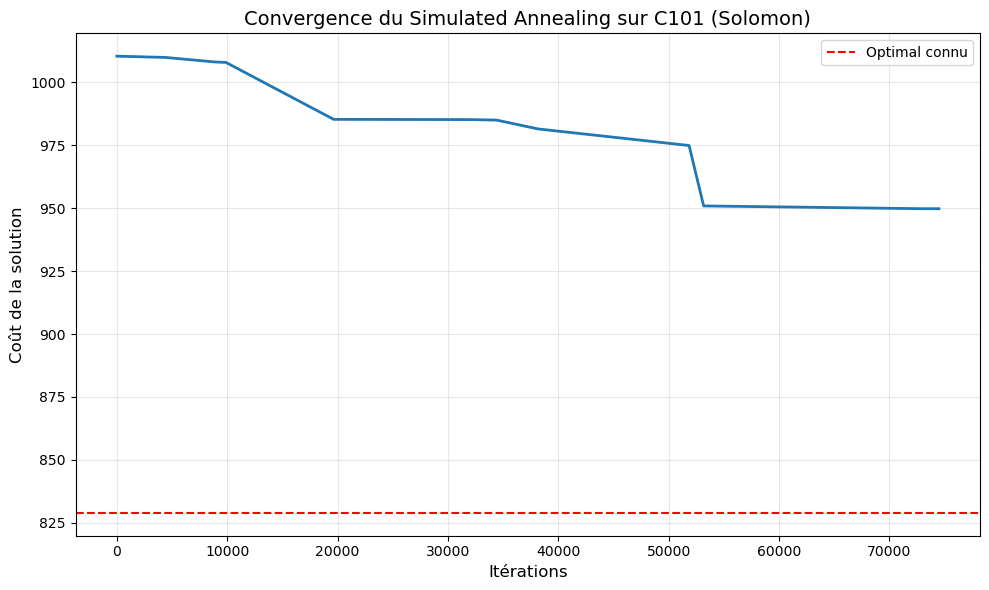


Routes obtenues :
Route 1: 0 → 63 → 11 → 9 → 6 → 4 → 2 → 1 → 75 → 0
Route 2: 0 → 5 → 3 → 7 → 8 → 10 → 0
Route 3: 0 → 13 → 17 → 18 → 19 → 15 → 16 → 14 → 12 → 0
Route 4: 0 → 20 → 24 → 25 → 27 → 29 → 30 → 28 → 26 → 23 → 21 → 0
Route 5: 0 → 32 → 33 → 35 → 37 → 38 → 39 → 36 → 34 → 22 → 0
Route 6: 0 → 43 → 42 → 41 → 40 → 44 → 46 → 45 → 48 → 47 → 0
Route 7: 0 → 31 → 51 → 50 → 52 → 49 → 0
Route 8: 0 → 57 → 55 → 54 → 53 → 56 → 58 → 60 → 59 → 0
Route 9: 0 →  → 0
Route 10: 0 → 67 → 65 → 62 → 74 → 72 → 61 → 64 → 68 → 66 → 69 → 0
Route 11: 0 → 81 → 78 → 76 → 71 → 70 → 73 → 77 → 79 → 80 → 0
Route 12: 0 → 90 → 87 → 86 → 83 → 82 → 84 → 85 → 88 → 89 → 91 → 0
Route 13: 0 → 98 → 96 → 95 → 94 → 92 → 93 → 97 → 100 → 99 → 0


In [3]:
# Accès direct aux résultats
print(f"Coût final : {results.cost:.2f}")
print(f"Temps d'exécution : {results.time_seconds:.2f}s")
print(f"Nombre d'itérations : {results.n_iterations}")
print(f"Gap vs optimal (828.94) : {((results.cost - 828.94) / 828.94 * 100):.2f}%")

# Courbe de convergence
import matplotlib.pyplot as plt

iterations = [p.iteration for p in results.convergence]
costs = [p.cost for p in results.convergence]

plt.figure(figsize=(10, 6))
plt.plot(iterations, costs, linewidth=2)
plt.axhline(y=828.94, color='r', linestyle='--', label='Optimal connu')
plt.xlabel("Itérations", fontsize=12)
plt.ylabel("Coût de la solution", fontsize=12)
plt.title("Convergence du Simulated Annealing sur C101 (Solomon)", 
          fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Solution détaillée
print("\nRoutes obtenues :")
for i, route in enumerate(results.solution):
    print(f"Route {i+1}: 0 → {' → '.join(map(str, route))} → 0")

**Pourquoi un si grand gap ?** Simplement car le but de cet exemple est de rapidement montrer le fonctionnement, et non pas de réellement faire l'analyse complète ici, regardez L2P3 pour l'analyse complète.

### 8.4. SYNTHÈSE DE L'ARCHITECTURE

Cette architecture modulaire, inspirée des principes du software engineering pour l'optimisation combinatoire, offre plusieurs avantages critiques :
* **Testabilité :** Chaque module peut être testé indépendamment avec des tests unitaires, suivant les pratiques du [Test Driven Developpement¹](#1), ces tests se trouvent dans `framework/Tests`
* **Extensibilité :** Ajouter un nouveau solver, opérateur ou constructeur ne nécessite aucune modification du code existant (principe Open/Closed)
* **Maintenabilité :** Un bug dans l'évaluation ne nécessite de modifier qu'un seul fichier, réduisant le risque de régression
* **Réutilisabilité :** Les mêmes opérateurs servent à tous les solvers (LocalSearch, SA, ALNS, Tabu), évitant la duplication de code
* **Reproductibilité :** Le RunFileManager garantit la traçabilité complète de chaque expérimentation, conformément aux standards de recherche reproductible, il permet également de ne pas avoir à refaire des calculs déjà existant.
* **Scalabilité :** Le SolverManager permet de lancer facilement des études expérimentales à grande échelle (batch processing)

Cette séparation des préoccupations permet également **une parallélisation future** : le SolverManager pourrait distribuer les expérimentations sur plusieurs cœurs ou machines sans modifier la logique des solvers eux-mêmes.

## **9. DU MODÈLE MATHÉMATIQUE À L'IMPLÉMENTATION**

Cette section établit le **pont** entre la modélisation formelle de la **Partie 1** et l'implémentation concrète dans notre framework.

### **9.1. TRADUCTION DU MODÈLE EN CODE**

**Rappel P1 - Modélisation formelle:**
- Graphe: $G=(V,E)$ avec $V=\{0\}\cup C$
- Fonction objectif: $\min \sum_{k \in K} \sum_{(i,j) \in E} d_{ij} x_{ijk}$
- Contraintes: visite unique, capacité, fenêtres temporelles

**Correspondance modèle ↔ code:**

| Concept Mathématique | Implémentation | Fichier |
|---------------------|----------------|---------|
| Solution $s = \{R_1, ..., R_k\}$ | `Solution.routes: List[List[int]]` | `solutionclass.py` |
| Fonction objectif $f(s)$ | `solution.total_cost` | `routemanager.py` |
| Contraintes (Q, TW) | `evaluator.evaluate_route_fast()` | `routemanager.py` |
| Espace faisable $\mathcal{F}$ | `is_valid_vrp() == True` | `solutionclass.py` |
| Voisinage $\mathcal{N}(s)$ | `try_relocate`, `try_2opt`, `try_exchange` | `operators.py` |

**Exemple concret:**
```python
# MODÈLE: s = {R1=[1,3,5], R2=[2,4]} avec coût total f(s)
# CODE:
solution = Solution(instance_name="C101")
solution.routes = [[1, 3, 5], [2, 4]]
solution.total_cost = sum(solution.route_costs)  # = f(s)

# MODÈLE: Vérifier s ∈ F (solution faisable)
# CODE:
is_feasible, msg = solution.is_valid_vrp(instance, evaluator)
```

### **9.2. VOISINAGE: THÉORIE → PRATIQUE**

**P1:** Voisinage $\mathcal{N}(s)$ défini formellement par les opérateurs

**P2:** Chaque opérateur génère un voisin faisable:
```python
# Relocate: déplacer client 3 de route 0 → route 1, position 2
neighbor, delta = try_relocate(
    solution=current, evaluator=evaluator,
    client=3, from_route_idx=0, to_route_idx=1, position=2
)
# Si neighbor is not None → mouvement faisable
# delta = f(neighbor) - f(current)
```

**Propriété clé:** Les opérateurs **préservent la faisabilité**: $s \in \mathcal{F} \Rightarrow s' \in \mathcal{F}$

### **9.3. MÉTAHEURISTIQUES: FORMALISME → CODE**

#### **Simulated Annealing**

**P1 - Formalisme:**
- Critère Metropolis: $P = e^{-\Delta/T}$
- Refroidissement: $T_{k+1} = \alpha \times T_k$

**P2 - Code:**
```python
# Dans SimulatedAnnealingSolver.solve()
delta = neighbor.total_cost - self.current_solution.total_cost

if delta < 0:
    self._accept_move(neighbor)  # Amélioration
else:
    acceptance_prob = math.exp(-delta / self.temperature)
    if random.random() < acceptance_prob:
        self._accept_move(neighbor)  # Acceptation probabiliste
    else:
        self._reject_move()

self.temperature *= self.config.cooling_rate  # Refroidissement
```

#### **ALNS**

**P1 - Formalisme:**
- Destroy-Repair: $s' = \text{Repair}(\text{Destroy}(s))$
- Poids adaptatifs: $w_i^{(t+1)} = \lambda w_i^{(t)} + (1-\lambda)\pi_i^{(t)}$

**P2 - Code:**
```python
# Dans ALNSSolver.solve()

# 1. Sélection selon poids adaptatifs
destroy_op = self.destroy_weights.select_operator()
repair_op = self.repair_weights.select_operator()

# 2. Destruction
removed_customers = self._apply_destroy(destroy_op, n_remove)

# 3. Reconstruction
neighbor = self._apply_repair(repair_op, removed_customers)

# 4. Acceptation (critère SA)
if self._accept_solution(neighbor):
    score = self._calculate_score(neighbor)
    # 5. Mise à jour poids
    self.destroy_weights.record_score(destroy_op, score)
    self.repair_weights.record_score(repair_op, score)

# 6. Mise à jour périodique
if self.iteration % self.config.weight_update_interval == 0:
    self.destroy_weights.update_weights()
    self.repair_weights.update_weights()
```

### **9.4. VÉRIFICATION DE LA COHÉRENCE**
Notre implémentation respecte rigoureusement le modèle:

* **Espace:** `Solution` encode une partition des clients en routes  
* **Objectif:** `total_cost` = somme des distances euclidiennes  
* **Contraintes:** `RouteEvaluator` vérifie Q + TW  
* **Voisinage:** Opérateurs génèrent $s' \in \mathcal{N}(s)$ correctement  
* **Métaheuristiques:** SA et ALNS implémentent fidèlement les algorithmes formels  

**Cette cohérence est prouvée** par les tests unitaires (section 10).

## **10. VALIDATION ET DÉMONSTRATIONS**

### **10.1. SUITE DE TESTS EXISTANTE**

Notre framework dispose d'une **suite complète** dans `/framework/Tests/`:

```
Tests/
├── test_constructors.py      # Validation NN, Savings, Insertion
├── test_evaluator.py          # Validation RouteEvaluator
├── test_operators.py          # Validation relocate, 2opt, exchange
├── test_solution.py           # Validation classe Solution
└── test_solvers.py            # Validation SA et ALNS
```
**Couverture:**
- **Correction:** Résultats conformes aux attentes
-  **Faisabilité:** Toutes les solutions respectent les contraintes
-  **Reproductibilité:** Mêmes seeds → mêmes résultats
-  **Robustesse:** Gestion des cas limites

**Exécution:**
```bash
cd /livrable/L2/
pytest /framework/Tests -v #Tous les tests du dossier seront lancés.
```
```
# Dernière output : nov. 11 à 19h20

atf@Ashas-lvmxxr-u:/livrable/L2$ pytest framework/Tests -v
======================================================================================================================================= test session starts =======================================================================================================================================
platform linux -- Python 3.10.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /livrable/L2
plugins: anyio-4.11.0
collected 150 items                                                                                                                                                                                                                                                                                             

framework/Tests/test_constructors.py::test_nearest_neighbor_basic PASSED                                                                                                                                                                                                                    [  0%]
framework/Tests/test_constructors.py::test_nearest_neighbor_feasibility PASSED                                                                                                                                                                                                              [  1%]
...
framework/Tests/test_solutionclass.py::test_repr_and_str PASSED                                                                                                                                                                                                                             [100%]

======================================================================================================================================= 150 passed in 0.30s =======================================================================================================================================
```


### **10.2. DÉMONSTRATIONS PRATIQUES**

Passons aux **démos concrètes** sur instances réelles.

#### **10.2.1. Démo 1: Comparaison des Constructeurs**

In [4]:
import sys
sys.path.insert(0, '/livrable/L2/framework')

from filemanagers.instancefilemanager import InstanceFileManager
from solvermanager.routemanager import RouteEvaluator
from solvermanager.constructors import (nearest_neighbor, savings_constructor, 
                                        sequential_insertion)
import time

manager = InstanceFileManager("/data")
instance = manager.load_instance("C101")
evaluator = RouteEvaluator(instance)

constructors = {
    'Nearest Neighbor': nearest_neighbor,
    'Savings (Sequential)': lambda i,e: savings_constructor(i,e,parallel=False),
    'Savings (Parallel)': lambda i,e: savings_constructor(i,e,parallel=True),
    'Insertion (Cheapest)': lambda i,e: sequential_insertion(i,e,'cheapest'),
}

print("="*70)
print("COMPARAISON CONSTRUCTEURS - C101 (100 clients)")
print("="*70)
print(f"{'Constructeur':<25} {'Coût':>12} {'Véhicules':>10} {'Temps (s)':>10}")
print("-"*70)

results = []
for name, constructor in constructors.items():
    start = time.time()
    solution = constructor(instance, evaluator)
    elapsed = time.time() - start
    
    print(f"{name:<25} {solution.total_cost:>12.2f} {solution.n_vehicles_used:>10} {elapsed:>10.3f}")
    results.append((name, solution.total_cost))

print("="*70)
best_name, best_cost = min(results, key=lambda x: x[1])
print(f"\nMeilleur: {best_name} (Coût: {best_cost:.2f})")

COMPARAISON CONSTRUCTEURS - C101 (100 clients)
Constructeur                      Coût  Véhicules  Temps (s)
----------------------------------------------------------------------
Nearest Neighbor               1954.40         32      0.001
Savings (Sequential)           1125.20         15      0.015
Savings (Parallel)             1010.40         13      0.289
Insertion (Cheapest)           1138.70         11      0.837

Meilleur: Savings (Parallel) (Coût: 1010.40)


#### **10.2.2. Démo 2: SA vs ALNS**

In [5]:
"""
Exemple d'utilisation de l'ALNS solver via SolverManager

Ce script montre comment utiliser le SolverManager pour orchestrer
la résolution avec ALNS de manière propre et centralisée.
"""

from framework.solvermanager.solvermanager_exe import SolverManager
from framework.solvermanager.solvers.alns import ALNSConfig
from framework.solvermanager.solvers.annealing import SimulatedAnnealingConfig


def example_basic():
    """
    Exemple basique : configuration par défaut
    Le SolverManager gère tout l'orchestration
    """
    print("="*70)
    print("EXEMPLE 1: Configuration par défaut")
    print("="*70)
    
    # Crée le manager (une seule fois)
    manager = SolverManager()
    
    # Résout directement - le manager gère tout
    result = manager.run_experiment(
        instance_name="C101",
        solver_name="alns",
        config=ALNSConfig(
            max_iterations=5000,
            verbose=True,
            max_iterations_no_improvement=500,
        ),
        constructor="savings"  # ou "nearest_neighbor"
    )


def example_custom_operators():
    """
    Exemple avec opérateurs personnalisés
    """
    print("\n\n" + "="*70)
    print("EXEMPLE 2: Opérateurs personnalisés")
    print("="*70)
    
    manager = SolverManager()
    
    config = ALNSConfig(
        destroy_operators=['shaw', 'worst'],
        repair_operators=['regret3'],
        destroy_size_ratio=0.4,
        initial_temperature=2000.0,
        cooling_rate=0.9998,
        max_iterations=10000,
        verbose=True
    )
    
    result = manager.run_experiment(
        instance_name="C103",
        solver_name="alns",
        config=config,
        constructor="savings"
    )
    
    print(f"\nSolution finale : coût = {result.cost:.2f}")


def example_tuned_parameters():
    """
    Exemple avec paramètres finement réglés
    """
    print("\n\n" + "="*70)
    print("EXEMPLE 3: Paramètres finement réglés")
    print("="*70)
    
    manager = SolverManager()
    
    config = ALNSConfig(
        destroy_operators=['random', 'worst', 'shaw', 'route'],
        repair_operators=['greedy', 'regret2', 'regret3'],
        min_destroy_size=5,
        max_destroy_size=30,
        weight_decay=0.90,
        weight_update_interval=50,
        score_new_best=50.0,
        score_better=10.0,
        score_accepted=2.0,
        score_rejected=0.0,
        initial_temperature=1500.0,
        cooling_rate=0.9997,
        min_temperature=0.001,
        shaw_removal_randomness=8.0,
        max_time=60.0,
        max_iterations_no_improvement=2000,
        verbose=True,
        seed=42
    )
    
    result = manager.run_experiment(
        instance_name="C107",
        solver_name="alns",
        config=config,
        constructor="savings"
    )


def example_convergence_tracking():
    """
    Exemple montrant comment accéder à la convergence
    """
    print("\n\n" + "="*70)
    print("EXEMPLE 4: Tracking de la convergence")
    print("="*70)
    
    manager = SolverManager()
    
    config = ALNSConfig(
        max_iterations=3000,
        record_convergence=True,
        verbose=True
    )
    
    result = manager.run_experiment(
        instance_name="C208",
        solver_name="alns",
        config=config,
        constructor="savings"
    )
    
    # Accède à l'historique via le résultat
    convergence = result.convergence
    print(f"\nPoints enregistrés : {len(convergence)}")
    
    print("\nPremiers points :")
    for point in convergence[:5]:
        print(f"  Iteration {point.iteration:5d} : coût = {point.cost:.2f}")
    
    print("\nDerniers points :")
    for point in convergence[-5:]:
        print(f"  Iteration {point.iteration:5d} : coût = {point.cost:.2f}")


def example_comparison_with_SA():
    """
    Exemple comparant ALNS avec SA via le même manager
    """
    print("\n\n" + "="*70)
    print("EXEMPLE 5: Comparaison ALNS vs SA")
    print("="*70)
    
    manager = SolverManager()
    
    # Test SA
    print("\n--- Simulated Annealing ---")
    sa_result = manager.run_experiment(
        instance_name="C101",
        solver_name="simulated_annealing",
        config=SimulatedAnnealingConfig(
            max_iterations=5000,
            initial_temperature=2000.0,
            cooling_rate=0.999,
            verbose=True
        ),
        constructor="savings"
    )
    
    # Test ALNS - même instance, même constructeur
    print("\n--- ALNS ---")
    alns_result = manager.run_experiment(
        instance_name="C101",
        solver_name="alns",
        config=ALNSConfig(
            max_iterations=5000,
            initial_temperature=2000.0,
            cooling_rate=0.999,
            verbose=True
        ),
        constructor="savings"
    )
    
    # Comparaison
    print("\n--- Comparaison ---")
    
    if alns_result.cost < sa_result.cost:
        diff = sa_result.cost - alns_result.cost
        print(f"ALNS meilleur de {diff:.2f} "
              f"({100 * diff / sa_result.cost:.2f}%)")
    else:
        diff = alns_result.cost - sa_result.cost
        print(f"SA meilleur de {diff:.2f} "
              f"({100 * diff / alns_result.cost:.2f}%)")


def example_batch_experiments():
    """
    Bonus : lance plusieurs expériences facilement
    """
    print("\n\n" + "="*70)
    print("EXEMPLE 6: Expériences batch")
    print("="*70)
    
    manager = SolverManager()
    
    instances = ["C101", "C201", "C1_2_1", "C1_2_7", "RC101"]
    results = []
    
    for instance_name in instances:
        print(f"\nRésolution {instance_name}...")
        result = manager.run_experiment(
            instance_name=instance_name,
            solver_name="alns",
            config=ALNSConfig(
                max_iterations=3000,
                verbose=False  # Pas de spam pour batch
            ),
            constructor="savings"
        )
        results.append((instance_name, result))
        print(f"  {instance_name}: {result.cost:.2f} "
              f"(amélioration {result.additional_info['improvement_pct']:.1f}%)")
    
    # Statistiques globales
    avg_improvement = sum(r.additional_info['improvement_pct'] for _, r in results) / len(results)
    print(f"\nAmélioration moyenne : {avg_improvement:.2f}%")


# Run examples
if __name__ == "__main__":
    print("Running ALNS examples with SolverManager...\n")
    
    example_basic()
    example_custom_operators()
    example_tuned_parameters()
    example_convergence_tracking()
    example_comparison_with_SA()
    example_batch_experiments()
    
    print("\n" + "="*70)
    print("All examples completed!")
    print("="*70)

Running ALNS examples with SolverManager...

EXEMPLE 1: Configuration par défaut

Experiment: C101 + alns
[1/6] Loading instance 'C101'...
      → 100 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded



EXEMPLE 2: Opérateurs personnalisés

Experiment: C103 + alns
[1/6] Loading instance 'C103'...
      → 100 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded


Solution finale : coût = 865.10


EXEMPLE 3: Paramètres finement réglés

Experiment: C107 + alns
[1/6] Loading instance 'C107'...
      → 100 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded



EXEMPLE 4: Tracking de la convergence

Experiment: C208 + alns
[1/6] Loading instance 'C208'...
      → 100 clients, capacity=700
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded


Points enregistrés : 3006

Premiers points :
  Iteration     0 : coût = 709.40
  Iteration     1 : coût = 644.30
  Iteration   

#### **10.2.3. Démo 3: Courbes de Convergence**


Experiment: C101 + alns
[1/6] Loading instance 'C101'...
      → 100 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded


Experiment: C101 + simulated_annealing
[1/6] Loading instance 'C101'...
      → 100 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded



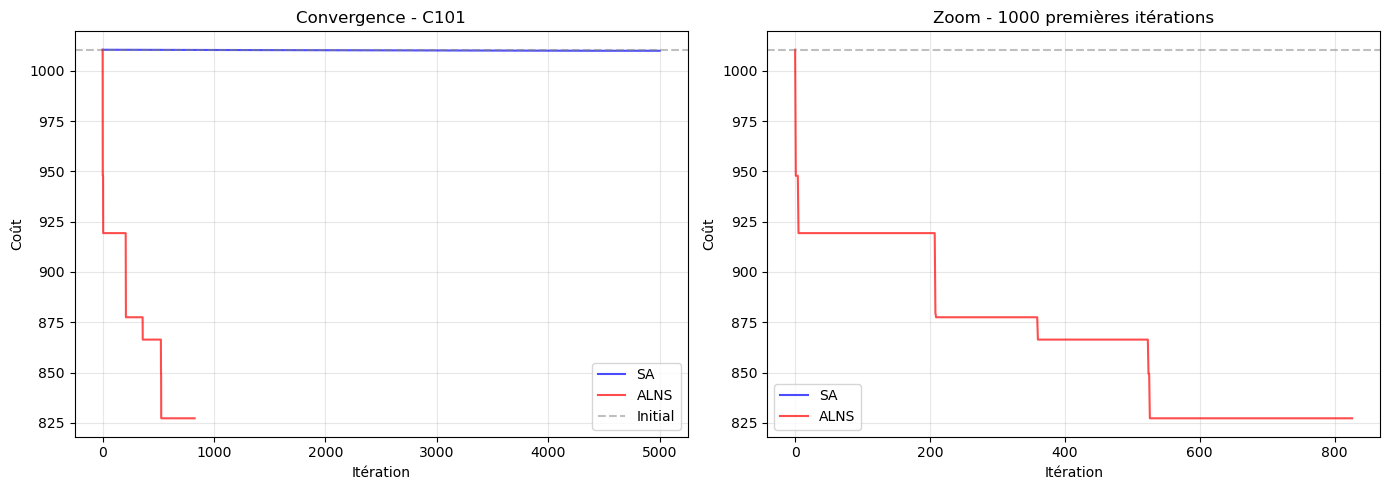

✓ Graphique: /outputs/convergence_C101.png
Coût initial : 1010.40
Coût final SA : 1009.90
Coût final ALNS : 827.30


In [6]:
from framework.solvermanager.solvermanager_exe import SolverManager
from framework.solvermanager.solvers.alns import ALNSConfig
from framework.solvermanager.solvers.annealing import SimulatedAnnealingConfig
import matplotlib.pyplot as plt

manager = SolverManager()

# --- ALNS ---
alns_result = manager.run_experiment(
    instance_name="C101",
    solver_name="alns",
    config=ALNSConfig(
        record_convergence=True,
        max_iterations=5000,
        initial_temperature=2000,
        cooling_rate=0.9995,
        verbose=True,
        seed=42,
        max_iterations_no_improvement=300,
    ),
    constructor="savings"
)

# --- SA ---
sa_result = manager.run_experiment(
    instance_name="C101",
    solver_name="simulated_annealing",
    config=SimulatedAnnealingConfig(
        record_convergence=True,
        max_iterations=5000,
        initial_temperature=2000,
        cooling_rate=0.9995,
        verbose=True,
        seed=42,
        max_iterations_no_improvement=10000,
        
    ),
    constructor="savings"
)

# --- Convergence data ---
sa_iters  = [p.iteration for p in sa_result.convergence]
sa_costs  = [p.cost for p in sa_result.convergence]
alns_iters = [p.iteration for p in alns_result.convergence]
alns_costs = [p.cost for p in alns_result.convergence]
initial_cost = alns_result.additional_info['initial_cost']

# --- Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(sa_iters, sa_costs, 'b-', alpha=0.7, label='SA', linewidth=1.5)
ax1.plot(alns_iters, alns_costs, 'r-', alpha=0.7, label='ALNS', linewidth=1.5)
ax1.axhline(y=initial_cost, color='gray', linestyle='--', label='Initial', alpha=0.5)
ax1.set_xlabel('Itération')
ax1.set_ylabel('Coût')
ax1.set_title('Convergence - C101')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom on first 1000 iterations
max_iter = 1000
ax2.plot(
    [i for i, c in zip(sa_iters, sa_costs) if i <= max_iter],
    [c for i, c in zip(sa_iters, sa_costs) if i <= max_iter],
    'b-', alpha=0.7, label='SA', linewidth=1.5
)
ax2.plot(
    [i for i, c in zip(alns_iters, alns_costs) if i <= max_iter],
    [c for i, c in zip(alns_iters, alns_costs) if i <= max_iter],
    'r-', alpha=0.7, label='ALNS', linewidth=1.5
)
ax2.axhline(y=initial_cost, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Itération')
ax2.set_ylabel('Coût')
ax2.set_title(f'Zoom - {max_iter} premières itérations')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Graphique: /outputs/convergence_C101.png")
print(f"Coût initial : {initial_cost:.2f}")
print(f"Coût final SA : {sa_result.cost:.2f}")
print(f"Coût final ALNS : {alns_result.cost:.2f}")


**Interprétation:**
- **SA:** Descente progressive (exploitation locale)
- **ALNS:** Descente avec "sauts" (exploration par destroy-repair)
- **Phase initiale:** ALNS explore plus largement
- **Phase finale:** Convergence vers optima locaux différents

#### **10.2.4. Démo 4: Validation BKS avec SolverManager**

In [7]:
from solvermanager.solvermanager_exe import SolverManager

# Initialisation
solver_manager = SolverManager(data_dir="/data", results_dir="/results")

# Instances test
test_instances = ['C1_10_1', 'C201', 'C103', 'C1_2_1']

print("="*90)
print("VALIDATION SUR BKS (BEST KNOWN SOLUTIONS)")
print("="*90)
print(f"{'Instance':<10} {'BKS':>10} {'Initial':>10} {'SA':>10} {'Gap SA':>10} "
      f"{'ALNS':>10} {'Gap ALNS':>10}")
print("-"*90)

results_summary = []

for inst_name in test_instances:
    # Chargement instance + BKS
    instance = solver_manager.instance_manager.load_instance(inst_name)
    bks_solution = solver_manager.instance_manager.load_solution(inst_name)
    
    # Extraction BKS
    bks_cost = bks_solution.cost
    
    # Config rapide (5000 iter pour démo)
    sa_config = SimulatedAnnealingConfig(
        initial_temperature=2000, cooling_rate=0.9995,
        max_iterations=5000, verbose=True, seed=42, max_iterations_no_improvement = 10000
    )
    
    alns_config = ALNSConfig(
        initial_temperature=2000, cooling_rate=0.9995,
        max_iterations=5000, destroy_size_ratio=0.3,
        verbose=True, seed=42, max_iterations_no_improvement = 300, max_time=2000
    )
    
    # Run SA
    sa_results = solver_manager.run_experiment(
        instance_name=inst_name, solver_name='simulated_annealing',
        config=sa_config, constructor='savings_parallel',
        seed=42
    )
    
    # Run ALNS
    alns_results = solver_manager.run_experiment(
        instance_name=inst_name, solver_name='alns',
        config=alns_config, constructor='savings',
        seed=42
    )
    
    # Calcul gaps
    if bks_cost:
        gap_sa = 100 * (sa_results.cost - bks_cost) / bks_cost
        gap_alns = 100 * (alns_results.cost - bks_cost) / bks_cost
    else:
        gap_sa, gap_alns = None, None
    
    # Affichage
    bks_str = f"{bks_cost:.2f}" if bks_cost else "N/A"
    gap_sa_str = f"{gap_sa:>9.2f}%" if gap_sa is not None else "N/A"
    gap_alns_str = f"{gap_alns:>9.2f}%" if gap_alns is not None else "N/A"
    
    print(f"{inst_name:<10} {bks_str:>10} {sa_results.additional_info['initial_cost']:>10.2f} "
          f"{sa_results.cost:>10.2f} {gap_sa_str:>10} "
          f"{alns_results.cost:>10.2f} {gap_alns_str:>10}")
    
    results_summary.append({
        'instance': inst_name, 'bks': bks_cost,
        'sa_cost': sa_results.cost,
        'alns_cost': alns_results.cost,
        'gap_sa': gap_sa, 'gap_alns': gap_alns
    })

print("="*90)

# Statistiques
valid_sa = [r['gap_sa'] for r in results_summary if r['gap_sa'] is not None]
valid_alns = [r['gap_alns'] for r in results_summary if r['gap_alns'] is not None]

if valid_sa and valid_alns:
    print(f"\n Statistiques:")
    print(f"  SA   - Gap moyen: {sum(valid_sa)/len(valid_sa):.2f}%, "
          f"Min: {min(valid_sa):.2f}%, Max: {max(valid_sa):.2f}%")
    print(f"  ALNS - Gap moyen: {sum(valid_alns)/len(valid_alns):.2f}%, "
          f"Min: {min(valid_alns):.2f}%, Max: {max(valid_alns):.2f}%")
    
    alns_wins = sum(1 for r in results_summary if r['alns_cost'] < r['sa_cost'])
    print(f"\n ALNS meilleur sur {alns_wins}/{len(results_summary)} instances")

print("\n  Budget limité (5000 iter).")

VALIDATION SUR BKS (BEST KNOWN SOLUTIONS)
Instance          BKS    Initial         SA     Gap SA       ALNS   Gap ALNS
------------------------------------------------------------------------------------------

Experiment: C1_10_1 + simulated_annealing
[1/6] Loading instance 'C1_10_1'...
      → 1000 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] Found existing results — loaded


Experiment: C1_10_1 + alns
[1/6] Loading instance 'C1_10_1'...
      → 1000 clients, capacity=200
[2/6] Creating evaluator...
[LOAD] No existing results found.
[3/6] Building initial solution with 'savings'...
      → Cost: 56375.20, Vehicles: 130
[4/6] Solving with 'alns'...
[ALNSSolver] Starting solve...
  Initial cost: 56375.20
  Initial vehicles: 130

ALNS SOLVER - Starting optimization
Initial cost: 56375.20
Vehicles: 130
Customers: 1000
Destroy operators: ['random', 'worst', 'shaw']
Repair operators: ['greedy', 'regret2']
Destroy size: 100-300 customers (30%)
Initial temperature: 2000.00
Coolin

## **BIBLIOGRAPHIE**

<a id="1">1</a> — Martraire, Cyrille • Thiéfaine, Arnaud • Bartaguiz, Dorra -  [Software craft : TDD, Clean Code et autres pratiques essentielles (scholarvox) ](https://univ.scholarvox.com/catalog/book/docid/88970637)

<a id="2">2</a> — Augerat, P., et al. (1995). [Computational results with a branch and cut code for the capacitated vehicle routing problem. Research Report RR-1991-05, ARTEMIS-IMAG.](https://www.osti.gov/etdeweb/servlets/purl/289002.)

<a id="3">3</a> — VRP-REP: [Vehicle Routing Problem Repository. (2024). Standardized benchmark instances and solutions.](http://www.vrp-rep.org/) & CVRPLIB [Capacitated Vehicle Routing Problem Library](https://vrp.galgos.inf.puc-rio.br/index.php/en/)

<a id="4">4</a> — Solomon, M. M. (1987). [Algorithms for the Vehicle Routing and Scheduling Problems with Time Window Constraints. Operations Research, 35(2), pages 254-265.](https://www.jstor.org/stable/171697) PAYANT

<a id="5">5</a> — Glover, F & A.Kochenberger, G (2003). [Handbook of metaheuristics (1st edition)](https://scispace.com/pdf/handbook-of-metaheuristics-3ue3f2vgdx.pdf)

<a id="6">6</a> — Talbi, E.-G. (2009). [Metaheuristics :  From design to implementation](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.researchgate.net/profile/Sura-Abdullah-5/post/What_is_the_proper_balance_between_Exploration_and_Selection_in_metaheuristics/attachment/5ff75b60e35e2b000103c944/AS%253A977419192246274%25401610046303870/download/Metaheuristics.pdf&ved=2ahUKEwit6JCGn-WQAxXSVaQEHUVgBboQFnoECAsQAQ&usg=AOvVaw37Og_lA_cJmRcElAXXGJf2)

<a id="7">7</a> — Gendreau, M., Hertz, A., & Laporte, G. (1994). [A Tabu Search Heuristic for the Vehicle Routing Problem. Management Science, 40(10), pages 1276-1290.](https://www.researchgate.net/publication/221704721_A_Tabu_Search_Heuristic_for_the_Vehicle_Routing_Problem)

<a id="8">8</a> — Rosenkrantz, D. J., Stearns, R. E., & Lewis, P. M. (1977). [An Analysis of Several Heuristics for the Traveling Salesman Problem. SIAM Journal on Computing, 6(3), pages 563-581.](https://www.researchgate.net/publication/220616869_An_Analysis_of_Several_Heuristics_for_the_Traveling_Salesman_Problem)

<a id="9">9</a> — Clarke, G., & Wright, J. W. (1964). [Scheduling of Vehicles from a Central Depot to a Number of Delivery Points. Operations Research, 12(4), pages 568-581.](https://pubsonline.informs.org/doi/10.1287/opre.12.4.568) PAYANT

<a id="10">10</a> — Aarts, E., & Lenstra, J. K. (2003). [Local Search in Combinatorial Optimization. Princeton University Press.](https://press.princeton.edu/books/paperback/9780691115221/local-search-in-combinatorial-optimization?srsltid=AfmBOooJ_ILZL63St7AfP2hfRXTZqftiphQVJCUP44isFwljyH3wYOaG) PAYANT

<a id="11">11</a> — Savelsbergh, M. W. (1992). [The Vehicle Routing Problem with Time Windows: Minimizing Route Duration. INFORMS Journal on Computing, 4(2), pages 146-154.](https://www.researchgate.net/publication/220669318_The_Vehicle_Routing_Problem_with_Time_Windows_Minimizing_Route_Duration)

<a id="12">12</a> — Croes, G. A. (1958). [A Method for Solving Traveling-Salesman Problems. Operations Research, 6(6), pages 791-812.](https://pubsonline.informs.org/doi/pdf/10.1287/opre.6.6.791) PAYANT

<a id="13">13</a> — Osman, I. H. (1993). [Metastrategy simulated annealing and tabu search algorithms for the vehicle routing problem. Annals of Operations Research, 41(4), pages 421-451.](https://link.springer.com/article/10.1007/BF02023004) PAYANT

<a id="14">14</a> — Kirkpatrick, S., Gelatt, C. D., & Vecchi, M. P. (1983). [Optimization by Simulated Annealing. Science, 220(4598), pages 671-680.](https://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/TemperAnneal/KirkpatrickAnnealScience1983.pdf)

<a id="15">15</a> — Metropolis, N., et al. (1953). [Equation of State Calculations by Fast Computing Machines. The Journal of Chemical Physics, 21(6), pages 1087-1092.](https://bayes.wustl.edu/Manual/EquationOfState.pdf)

<a id="16">16</a> — Ropke, S., & Pisinger, D. (2006). [An Adaptive Large Neighborhood Search Heuristic for the Pickup and Delivery Problem with Time Windows. Transportation Science, 40(4), pages 455-472.](https://www.researchgate.net/publication/220413334_An_Adaptive_Large_Neighborhood_Search_Heuristic_for_the_Pickup_and_Delivery_Problem_with_Time_Windows)

<a id="17">17</a> — Shaw, P. (1999). [Using Constraint Programming and Local Search Methods to Solve Vehicle Routing Problems. In Principles and Practice of Constraint Programming (pages 417-431).](https://link.springer.com/chapter/10.1007/3-540-49481-2_30) PAYANT

<a id="18">18</a> — Potvin, J. Y., & Rousseau, J. M. (1993). [A parallel route building algorithm for the vehicle routing and scheduling problem with time windows. European Journal of Operational Research, 66(3), pages 331-340.](https://www.sciencedirect.com/science/article/abs/pii/0377221793902218) PAYANT

<a id="19">19</a> — Goldberg, D. E., & Deb, K. (1991). [A Comparative Analysis of Selection Schemes Used in Genetic Algorithms. Foundations of Genetic Algorithms, 1, pages 69-93.](https://www.sciencedirect.com/science/chapter/bookseries/abs/pii/B9780080506845500082) PAYANT

<a id="20">20</a> — Sutton, R. S., & Barto, A. G. (2018). [Reinforcement Learning: An Introduction (2nd edition). MIT Press.](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

<a id="21">21</a> — Pisinger, D., & Ropke, S. (2007). [A general heuristic for vehicle routing problems. Computers & Operations Research, 34(8), pages 2403-2435.](https://backend.orbit.dtu.dk/ws/portalfiles/portal/3154462/A%20general%20heuristic%20for%20vehicle%20routing%20problems_TechRep_Pisinger_Ropke.pdf)

<a id="22">22</a> — Solomon, M. M. (1987). [Algorithms for the Vehicle Routing and Scheduling Problems with Time Window Constraints. Operations Research, 35(2), pages 254-265.](https://www.semanticscholar.org/paper/Algorithms-for-the-Vehicle-Routing-and-Scheduling-Solomon/586d63ddc8b328337966f15296ecc203ff05d9bd)